In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def plot_boxes(image, outputs):
    # Convert tensor outputs to numpy array
    outputs = outputs[0].cpu().numpy()

    # Create a figure and a set of subplots
    fig, ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(image)

    # Set class labels (assuming 3 classes as described: clear, cloudy, amber)
    class_labels = {0: 'clear', 1: 'cloudy', 2: 'amber'}
    
    # Define colors for different classes
    colors = {0: 'grey', 1: 'white', 2: 'orange'}

    # Add the patch to the Axes
    for output in outputs.boxes.data:
        x, y, xmax, ymax, confidence, cls_id = output
        cls_id = int(cls_id)
        rect = patches.Rectangle((x, y), xmax - x, ymax - y, linewidth=1, edgecolor=colors[cls_id], facecolor='none', label=class_labels[cls_id])
        ax.add_patch(rect)
    
    # Set legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Removing duplicates in legend
    ax.legend(by_label.values(), by_label.keys())

    plt.show()
    
# Function to plot only the ground truth bounding boxes
def plot_ground_truth(image, ground_truths):
    """
    Plots only the ground truth bounding boxes on the image.

    Args:
        image (PIL Image): The image on which to plot.
        ground_truths (list): List of dictionaries containing ground truth boxes with 'bbox' and 'class_id'.
    """
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Set class labels (assuming 3 classes as described: clear, cloudy, amber)
    class_labels = {0: 'clear', 1: 'cloudy', 2: 'amber'}
    
    # Define colors for different classes
    gt_colors = {0: 'darkgrey', 1: 'lightgrey', 2: 'goldenrod'}

    # Plot ground truth boxes
    for gt in ground_truths:
        x_min, y_min, x_max, y_max = gt['bbox']
        cls_id = gt['class_id']
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=gt_colors[cls_id], facecolor='none', linestyle='dashed', label=class_labels[cls_id])
        ax.add_patch(rect)

    # Set legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Removing duplicates in legend
    ax.legend(by_label.values(), by_label.keys())

    plt.show()



In [71]:
def parse_yolo_annotation(file_path, image_size):
    ground_truths = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1]) * image_size
            y_center = float(parts[2]) * image_size
            width = float(parts[3]) * image_size
            height = float(parts[4]) * image_size
            x_min = x_center - width / 2
            y_min = y_center - height / 2
            x_max = x_center + width / 2
            y_max = y_center + height / 2
            ground_truths.append({
                'bbox': [x_min, y_min, x_max, y_max],
                'class_id': class_id})
    return ground_truths


def parse_yolo_output(outputs):
    parsed_outputs = []
    for detection in outputs:
        x_min, y_min, x_max, y_max, confidence, class_id = detection.cpu().numpy()

        parsed_outputs.append({
            'bbox': [x_min, y_min, x_max, y_max],
            'score': confidence,
            'class_id': int(class_id)
        })
    return parsed_outputs


### Ultralytics model Evaluator
Here I would calc the metrics and function for evaluating the Ultralytics models.

In [29]:
image = "/home/etaylor/images/processed_images/cannabis_patches/week9_15_06_2023/3x_regular/IMG_2157/IMG_2157_p4.png"

In [ ]:
# Replace these with the actual dimensions of your image
img_size = 512

# Path to the YOLO annotation file
annotation_path = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/annotations/yolo_split/labels/IMG_2157_p4.txt'
ground_truths = parse_yolo_annotation(annotation_path, img_size)

In [75]:
from ultralytics import YOLO

yolov8_checkpoint = "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/ultralytics/runs/old/train16/weights/best.pt"
predictor = YOLO(yolov8_checkpoint)
outputs = predictor(image, imgsz=512, verbose=False, conf=0.3)

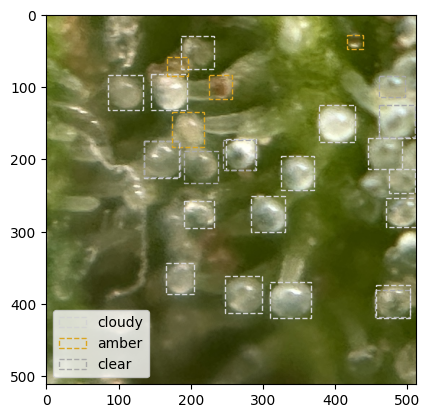

In [31]:
plot_ground_truth(Image.open(image), ground_truths)

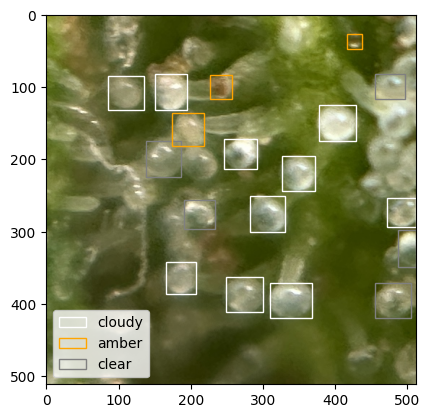

In [5]:

# Usage: Assuming `image` is a PIL Image and `outputs` is your YOLO output tensor
plot_boxes(Image.open("/home/etaylor/images/processed_images/cannabis_patches/week9_15_06_2023/3x_regular/IMG_2157/IMG_2157_p4.png"), outputs)

In [90]:
def iou(boxA, boxB):
    """ Calculate the Intersection over Union (IoU) of two bounding boxes."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou



def compute_confusion_matrix(matches, false_positives, false_negatives, num_classes, gt_boxes, pred_boxes):
    """Compute confusion matrix based on matches and misclassifications."""
    cm = np.zeros((num_classes, num_classes), dtype=int)

    # Increment true positives
    for match in matches:
        gt_idx, pred_idx, _ = match
        cm[gt_boxes[gt_idx]['class_id'], pred_boxes[pred_idx]['class_id']] += 1

    # Increment false positives
    for fp in false_positives:
        cm[-1, fp['class_id']] += 1  # Assuming -1 is a "background" class

    # Increment false negatives
    for fn in false_negatives:
        cm[fn['class_id'], -1] += 1

    return cm


def match_predictions_all(gt_boxes, pred_boxes, iou_thresh=0.5):
    """Match predictions to ground truth boxes based on IoU threshold, and classify predictions."""
    matches = []
    detected = []
    false_positives = []
    unmatched_gts = set(range(len(gt_boxes)))

    for pred_idx, pred in enumerate(pred_boxes):
        best_iou = 0
        best_match = None

        for gt_idx, gt in enumerate(gt_boxes):
            if gt['class_id'] == pred['class_id']:
                current_iou = iou(pred['bbox'], gt['bbox'])
                if current_iou > best_iou:
                    best_iou = current_iou
                    best_match = (gt_idx, pred_idx, best_iou)

        if best_match and best_iou >= iou_thresh:
            if best_match[0] not in detected:
                matches.append(best_match)
                detected.append(best_match[0])
                unmatched_gts.discard(best_match[0])
            else:
                false_positives.append(pred)
        else:
            false_positives.append(pred)

    false_negatives = [{'bbox': gt['bbox'], 'class_id': gt['class_id']} for gt_idx, gt in enumerate(gt_boxes) if gt_idx in unmatched_gts]

    return matches, false_positives, false_negatives


def calculate_metrics(matches, detected, gt_boxes, pred_boxes):
    """ Calculate precision and recall based on matched predictions."""
    true_positives = len(matches)
    false_positives = len(pred_boxes) - true_positives
    false_negatives = len(gt_boxes) - len(detected)

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    return {"precision": precision, "recall": recall}


def evaluate_predictions(gt_boxes, pred_boxes, num_classes, iou_thresh=0.5):
    pred_boxes = parse_yolo_output(pred_boxes)
    matches, false_positives, false_negatives = match_predictions_all(gt_boxes, pred_boxes, iou_thresh)
    metrics = calculate_metrics(matches, detected=[match[0] for match in matches], gt_boxes=gt_boxes, pred_boxes=pred_boxes)
    confusion_matrix = compute_confusion_matrix(matches, false_positives, false_negatives, num_classes, gt_boxes, pred_boxes)

    return {"metrics": metrics, "confusion_matrix": confusion_matrix}



In [93]:
predictions = outputs[0].boxes.data

result = evaluate_predictions(ground_truths, predictions, num_classes=3)
print(f"metrics: {result['metrics']}, \nconfusion_matrix: {result['confusion_matrix']}")

metrics: {'precision': 0.8, 'recall': 0.7407407407407407}, 
confusion_matrix: [[ 5  0  1]
 [ 0 12  5]
 [ 3  2  4]]
